## Easy Experiment .ipynb File

### <font color='red'><b> 🐬 기억합시다 :] 실험마다 인덱스 붙여서 파일 새로만들기~! <b></font>

### unseen data로 validation을 측정하는 실험

## import

In [208]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random
import time
from datetime import timedelta
import shutil

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_model_summary import summary

from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [209]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [210]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [211]:
### cofiguration
seed = 42
check_point_dir_name = 'age3'
data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 300
train_ratio = 0.8
epochs = 20
print_interval = 338
lr = 3e-4
model_name = 'convnext_tiny'
num_labels = 1
loss_function_name = 'MSELoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
weight_decay = 0.02
scheduler_name = 'CosineAnnealingWarmRestarts'
comment = f'gender_cls를 구분하기 위한 모델'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [212]:
df_train = pd.read_csv('./dataset/train/hypothesis_train.csv')
df_valid = pd.read_csv('./dataset/train/hypothesis_valid.csv')

In [213]:
df_train = df_train[df_train['mask_class']==0]

In [214]:
## num of dset
print(len(df_train), len(df_valid))

10800 3780


In [215]:
os.makedirs(save_dir,exist_ok=True)

In [216]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : lr,
'model_name' : model_name,
'num_labels' : num_labels,
'train_ratio': train_ratio,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'weight_decay' : weight_decay,
'scheduler_name' : scheduler_name,
'comment' : comment
}

In [217]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [218]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy(dtype=np.float32)
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [219]:
train_transforms = A.Compose([
        A.CenterCrop(height=450,width=250),
        A.HorizontalFlip(p=0.5),
        A.Resize(224, 224),
        A.CLAHE(p=1.,clip_limit=6.0),
        A.ToGray(p=1.),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])
    
valid_transforms = A.Compose([
        A.CenterCrop(height=450,width=250),
        A.HorizontalFlip(p=0.5),
        A.Resize(224, 224),
        A.CLAHE(p=1.,clip_limit=6.0),
        A.ToGray(p=1.),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])

## make dataset and dataloader

In [220]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,path,mask_class,gender_class,age,origin_label,age_cls,people
0,0,0,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,middle,000001_female_Asian_45
3,3,3,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,middle,000001_female_Asian_45
4,4,4,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,middle,000001_female_Asian_45
5,5,5,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,middle,000001_female_Asian_45
6,6,6,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,middle,000001_female_Asian_45


In [221]:
def age_to_class(age):
    cls = None
    if age<30:
        cls = 0
    elif 30<=age<60:
        cls = 1
    elif age>=60:
        cls = 2
    else:
        cls = None
    if cls == None:
        assert ValueError
    return cls


In [222]:
age_train_cls = []
age_valid_cls = []
for age in df_train['age']:
    age_train_cls.append(age_to_class(age))

for age in df_valid['age']:
    age_valid_cls.append(age_to_class(age))

In [223]:
df_train['age_cls'] = age_train_cls
df_valid['age_cls'] = age_valid_cls

In [224]:
df_train

,Unnamed: 0,Unnamed: 0.1,path,mask_class,gender_class,age,origin_label,age_cls,people
0,0,0,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,1,000001_female_Asian_45
3,3,3,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,1,000001_female_Asian_45
4,4,4,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,1,000001_female_Asian_45
5,5,5,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,1,000001_female_Asian_45
6,6,6,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,45,4,1,000001_female_Asian_45
...,...,...,...,...,...,...,...,...,...
15113,15113,15113,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,25,0,0,005444_male_Asian_25
15116,15116,15116,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,25,0,0,005444_male_Asian_25
15117,15117,15117,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,25,0,0,005444_male_Asian_25
15118,15118,15118,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,25,0,0,005444_male_Asian_25


In [225]:
df_valid

,Unnamed: 0,Unnamed: 0.1,path,mask_class,gender_class,age,origin_label,age_cls,people
0,15120,15120,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,53,4,1,005445_female_Asian_53
1,15121,15121,/opt/ml/repo/level1_imageclassification_cv-lev...,2,1,53,16,1,005445_female_Asian_53
2,15122,15122,/opt/ml/repo/level1_imageclassification_cv-lev...,1,1,53,10,1,005445_female_Asian_53
3,15123,15123,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,53,4,1,005445_female_Asian_53
4,15124,15124,/opt/ml/repo/level1_imageclassification_cv-lev...,0,1,53,4,1,005445_female_Asian_53
...,...,...,...,...,...,...,...,...,...
3775,18895,18895,/opt/ml/repo/level1_imageclassification_cv-lev...,1,0,19,6,0,006959_male_Asian_19
3776,18896,18896,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0,0,006959_male_Asian_19
3777,18897,18897,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0,0,006959_male_Asian_19
3778,18898,18898,/opt/ml/repo/level1_imageclassification_cv-lev...,0,0,19,0,0,006959_male_Asian_19


In [226]:
train_dset = CustomTrainDataset(df_train['path'], df_train['age'], 'class', train_transforms)
val_dset = CustomTrainDataset(df_valid['path'], df_valid['age'], 'class', valid_transforms)

In [227]:
type(train_dset[0][1])

numpy.float32

In [228]:
## num of iter(batches)
print(len(train_dset), len(val_dset))

10800 3780


In [229]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [230]:
print(len(train_loader))
print(len(val_loader))

338
13


## visualization transform

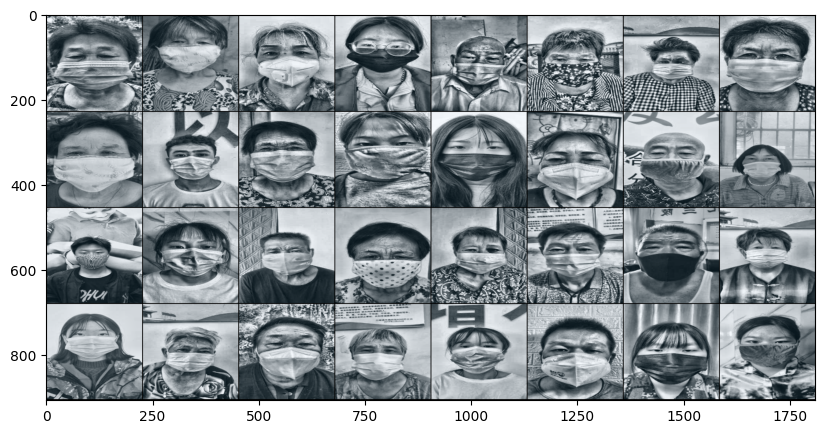

In [231]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

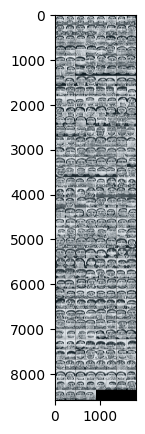

In [232]:
imgs, labels = next(iter(val_loader))
plt.figure(figsize=(10, 5))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [233]:
model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_labels)
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine

In [234]:
print(summary(model,torch.Tensor(2,3,224,224).to(device)))

-------------------------------------------------------------------------------
             Layer (type)         Output Shape         Param #     Tr. Param #
                 Conv2d-1      [2, 96, 56, 56]           4,704           4,704
            LayerNorm2d-2      [2, 96, 56, 56]             192             192
          ConvNeXtStage-3      [2, 96, 56, 56]         237,888         237,888
          ConvNeXtStage-4     [2, 192, 28, 28]         992,256         992,256
          ConvNeXtStage-5     [2, 384, 14, 14]      11,112,960      11,112,960
          ConvNeXtStage-6       [2, 768, 7, 7]      15,470,592      15,470,592
               Identity-7       [2, 768, 7, 7]               0               0
   SelectAdaptivePool2d-8       [2, 768, 1, 1]               0               0
            LayerNorm2d-9       [2, 768, 1, 1]           1,536           1,536
               Flatten-10             [2, 768]               0               0
               Dropout-11             [2, 768]     

## Loss function

In [235]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [236]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = None
elif loss_function_name == 'FocalLoss':
    criterion = None
elif loss_function_name == 'F1Loss':
    criterion = F1Loss(classes=num_labels)
elif loss_function_name == 'MSELoss':
    criterion = nn.MSELoss()
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

In [237]:
criterion

MSELoss()

## Optimizer

In [238]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay) # 0.09 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

In [239]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0.02
)

## Scheduler  

In [240]:
scheduler = None

if scheduler_name == 'ReduceLROnPlateau':
    ## during 5epochs, valid loss decrease 1e-3↓, lr update lr*0.5
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-3) ## 정리
elif scheduler_name == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-4)

assert scheduler != None , 'sheduler is None'

In [241]:
scheduler

## Train

In [242]:
best_val_loss = np.Inf
best_val_MAE = np.Inf

start=time.process_time()

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, b_labels = train_batch # batch imgs and batch labels
        b_imgs = b_imgs.to(device)
        b_labels = b_labels.unsqueeze(dim=1).to(device)

        b_reg = model(b_imgs)
        b_loss = criterion(b_reg.to(torch.float32), b_labels.to(torch.float32))

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        epoch_loss+=b_loss.item()
        iter_preds+=b_reg.detach().cpu().numpy().flatten().tolist() # for 1d dim
        iter_labels+=b_labels.detach().cpu().numpy().flatten().tolist() # for 1d dim

        epoch_preds+=iter_preds
        epoch_labels+=iter_labels

        iter_preds = []
        iter_labels = []

        # print interval batch
        if(idx+1) % print_interval == 0:
            current_loss = epoch_loss / (idx+1) # / batch
            correct_list = [abs(i-j) for i,j in zip(epoch_preds, epoch_labels)]
            epoch_MAE = mean_absolute_error(epoch_labels, epoch_preds)
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss(MSE) {current_loss:2.4f} || train MAE {epoch_MAE:2.4f} || "
                    f"lr {optimizer.param_groups[0]['lr']:.5f}"
                )
    
    scheduler.step()
    
    with torch.no_grad():
        print("    Calculating validation results...")
        model.eval()

        val_loss = []
        val_preds = [] 
        val_labels = []

        for idx, val_batch in enumerate(val_loader):
            imgs, labels = val_batch
            imgs = imgs.to(device)
            labels = labels.unsqueeze(dim=1).to(device)

            preds = model(imgs)
            b_loss = criterion(preds, labels).item()
            
            val_loss.append(b_loss)

            val_preds += preds.detach().cpu().numpy().flatten().tolist()
            val_labels += labels.detach().cpu().numpy().flatten().tolist()

            

        epoch_val_MAE = mean_absolute_error(val_labels, val_preds)
        epoch_val_MSE =  mean_squared_error(val_labels, val_preds)
        best_val_loss = min(best_val_loss, epoch_val_MSE)

        if epoch_val_MAE < best_val_MAE:
                print(f"  New best model for val MAE : {epoch_val_MAE:2.4f}! saving the best model..")
                best_val_MAE = epoch_val_MAE
                torch.save(model.state_dict(), f"{save_dir}/best.pth")
                
                
                
                list_total_preds = val_preds # if best score val-set, assign pred result to list_total_preds
                list_total_labels = val_labels # if best score val-set, assign pred result to list_total_preds

                df_diff = pd.DataFrame()
                df_diff['labels'] = list_total_labels
                df_diff['preds'] = list_total_preds
                df_diff.to_csv(f'{save_dir}/diff.csv')
                
        torch.save(model.state_dict(), f'{save_dir}/last.pth')
        print(
                f"    [{epoch+1} epoch Val] MAE:{epoch_val_MAE:2.4f}, loss(MSE):{epoch_val_MSE:2.4f} || "
                f"best MAE:{best_val_MAE:2.4f}, best loss(MSE):{best_val_loss:2.4f}"
            )
    print()
    src = './9_T4064_Experiment_people_age.ipynb'
    dst = f"{save_dir}/code.ipynb"
    shutil.copy(src,dst)
end = time.process_time()

Epoch[1/20](338/338) || training loss(MSE) 551.3548 || train MAE 19.9667 || lr 0.00030
    Calculating validation results...
  New best model for val MAE : 14.2481! saving the best model..
    [1 epoch Val] MAE:14.2481, loss(MSE):221.5171 || best MAE:14.2481, best loss(MSE):221.5171

Epoch[2/20](338/338) || training loss(MSE) 52.7866 || train MAE 5.2981 || lr 0.00028
    Calculating validation results...
  New best model for val MAE : 3.8682! saving the best model..
    [2 epoch Val] MAE:3.8682, loss(MSE):24.4929 || best MAE:3.8682, best loss(MSE):24.4929

Epoch[3/20](338/338) || training loss(MSE) 15.4200 || train MAE 2.8916 || lr 0.00023
    Calculating validation results...
    [3 epoch Val] MAE:4.0832, loss(MSE):29.2619 || best MAE:3.8682, best loss(MSE):24.4929

Epoch[4/20](338/338) || training loss(MSE) 9.7544 || train MAE 2.3442 || lr 0.00017
    Calculating validation results...
    [4 epoch Val] MAE:4.0219, loss(MSE):28.3120 || best MAE:3.8682, best loss(MSE):24.4929

Epoch[5/

```
resnet34 MSE
Epoch[16/20](338/338) || training loss(MSE) 2.7156 || train MAE 1.2476 || lr 0.00030
    Calculating validation results...
  New best model for val MAE : 3.0703! saving the best model..
    [16 epoch Val] MAE:3.0703, loss(MAE):23.2835 || best MAE:3.0703, best loss(MSE):22.9985
```

```
efficientnet_b4
Epoch[17/20](338/338) || training loss(MSE) 1.9332 || train MAE 1.0382 || lr 0.00028
    Calculating validation results...
  New best model for val MAE : 4.3478! saving the best model..
    [17 epoch Val] MAE:4.3478, loss(MSE):32.3770 || best MAE:4.3478, best loss(MSE):32.3770
```

```
convnext_tiny
```

## Result

In [ ]:
print("Time elapsed: ", timedelta(seconds=end-start))

## Error Analysis

In [ ]:
df_diff = pd.DataFrame()
df_diff['labels'] = list_total_labels
df_diff['preds'] = list_total_preds
df_diff.to_csv(f'{save_dir}/diff.csv')

In [ ]:
## label to sentence
def get_sentence(code):
    codebook = ['Wear,male,junior', # 0
                'Wear,male,middle', # 1
                'Wear,male,senior', # 2
                'Wear,female,junior', # 3
                'Wear,female,middle', # 4
                'Wear,female,senior', # 5
                'Incorrect,male,junior', # 6
                'Incorrect,male,middle', # 7
                'Incorrect,male,senior', # 8
                'Incorrect,female,junior', # 9
                'Incorrect,female,middle', # 10
                'Incorrect,female,senior', # 11
                'Not Wear,male,junior', # 12
                'Not Wear,male,middle', # 13
                'Not Wear,male,senior', # 14
                'Not Wear,female,junior', # 15
                'Not Wear,female,middle', # 16
                'Not Wear,female,senior'] # 17
    return codebook[code]

# age to sentence
def get_age_category(num):
    category = None
    if num>=60:
        category = 'senior'
    elif 30<=num<60:
        category = 'middle'
    else:
        category = 'junior'
    return category

In [ ]:
for_people.value_counts().to_csv(f'{save_dir}/error_cnt.csv')

In [ ]:
list_wear_labels = []
list_gender_labels = []
list_age_labels = []

list_wear_preds = []
list_gender_preds = []
list_age_preds = []

for label in df_diff['labels']:
    row = get_sentence(label).split(',')
    list_wear_labels.append(row[0])
    list_gender_labels.append(row[1])
    list_age_labels.append(row[2])

for label in df_diff['preds']:
    row = get_sentence(label).split(',')
    list_wear_preds.append(row[0])
    list_gender_preds.append(row[1])
    list_age_preds.append(row[2])

In [ ]:
list_cause = []
for row in zip(list_wear_labels, list_wear_preds, list_gender_labels, list_gender_preds, list_age_labels, list_age_preds):
    sentence = []
    if row[0] != row[1]:
        sentence.append(f'mask   : {row[0]} → {row[1]}')
    if row[2] != row[3]:
        sentence.append(f'gender : {row[2]} → {row[3]}')
    if row[4] != row[5]:
        sentence.append(f'age    : {row[4]} → {row[5]}')
    
    if len(sentence) == 0:
        sentence = "all correct"
    elif len(sentence) == 1:
        sentence = sentence[0]
    else: # len(sentence) == 2
        sentence = ','.join(sentence)
    list_cause.append(sentence)

In [ ]:
l = pd.Series(list_cause)
l.value_counts().sort_values(ascending = False)

```
normal f1 checkpoint
all correct                      3763
mask   : Incorrect → Wear           6
age    : middle → junior            6
age    : middle → senior            2
gender : male → female              1
mask   : Incorrect → Not Wear       1
mask   : Not Wear → Incorrect       1
dtype: int64
```

```
people split during this time, model memory people
if my hypothesis is right, f1 score will be 0.8 under
```

In [ ]:
df_diff['cause'] = list_cause
df_diff.to_csv(f'{save_dir}/analysis.csv')

## inference

## inference config

In [ ]:
model_name = 'efficientnetv2_rw_m'
check_point_dir_name = 'baseline2'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 500
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [ ]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=num_labels)
model.to(device)
model.load_state_dict(torch.load(save_file_path))
model = torch.nn.DataParallel(model)

## test dataset

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [ ]:
test_transforms = A.Compose([A.Resize(224, 224),
                             A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
                             ToTensorV2()])

In [ ]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [ ]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [ ]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [ ]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")